In [5]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import numpy as np
import os, argparse
import time
import torch
import bayes3d as b
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer

intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=75.0, fy=75.0,
    cx=50.0, cy=50.0,
    near=0.001, far=16.0
)
from bayes3d.rendering.nvdiffrast_jax.jax_renderer import Renderer as JaxRenderer
jax_renderer = JaxRenderer(intrinsics)


model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
idx = 17
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
m = b.utils.load_mesh(mesh_path)
m = b.utils.scale_mesh(m, 1.0/100.0)

vertices = jnp.array(m.vertices.astype(np.float32))
faces = jnp.array(m.faces.astype(np.int32))

pose = b.transform_from_pos(jnp.array([0.0, 0.0, 2.0]))
NUM_POSES = 50
poses = jnp.tile(pose[None,...], (NUM_POSES,1,1))
poses = poses.at[:,0,3].set(jnp.linspace(-1.0, 1.0, NUM_POSES))

In [10]:
imgs = jax_renderer.render_many(vertices, faces, poses, intrinsics)
viz_images = [b.get_depth_image(d) for d in imgs]

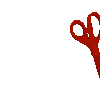

In [12]:
viz_images[-1]

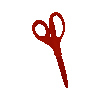

In [3]:
depth, _ = jax_renderer.render(vertices, faces, pose, intrinsics)
b.get_depth_image(depth[0])

(5, 100, 100)


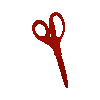

In [46]:
projection_matrix = b.camera._open_gl_projection_matrix(
    intrinsics.height, intrinsics.width, 
    intrinsics.fx, intrinsics.fy, 
    intrinsics.cx, intrinsics.cy, 
    intrinsics.near, intrinsics.far
)
composed_projection = projection_matrix @ poses
vertices_homogenous = jnp.concatenate([vertices, jnp.ones((*vertices.shape[:-1],1))], axis=-1)
clip_spaces_projected_vertices = jnp.einsum("nij,mj->nmi", composed_projection, vertices_homogenous)
rast_out, rast_out_db = jax_renderer.rasterize(clip_spaces_projected_vertices, faces, jnp.array([intrinsics.height, intrinsics.width]))
interpolated_collided_vertices_clip, _ = jax_renderer.interpolate(jnp.tile(vertices_homogenous[None,...],(poses.shape[0],1,1)), rast_out, faces, rast_out_db, jnp.array([0,1,2,3]))
interpolated_collided_vertices = jnp.einsum("a...ij,a...j->a...i", poses, interpolated_collided_vertices_clip)
mask = rast_out[...,-1] > 0
depth = interpolated_collided_vertices[...,2] * mask
print(depth.shape)
b.get_depth_image(depth[0])

In [36]:
interpolated_collided_vertices.shape

(3, 100, 100, 4)

Array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
 